In [1]:
#Librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import random, math
from scipy.optimize import minimize
from numpy.random import rand
%matplotlib inline 
plt.rcParams['figure.figsize'] = 14, 7 #ancho, alto

font = {'weight' : 'bold',
        'size'   : 15}


In [2]:
random.seed(1) # semilla inicial
h=np.arange(-25,25,1) #campo magnetico
h2=np.arange(25,-25,-1) #campo magnetico para histeresis

T=np.arange(1,105,5) #temperatura

In [3]:
#Función para el modelo de ising en 2D
def ising2D(L, T, nsteps, J,H):
  #L es el arista de la red cuadrada
  #T es la temperatura
  #nsteps es el número de pasos de montecarlo
  #J es la constante de intercambio
  #H es el campo magnético
  energy=0 #energía inicial
  N = L * L #número de espines
  beta = 1.0 / T
  nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) \
                                    for i in range(N)} #Vecinos de cada sitio
  S = [random.choice([1, -1]) for k in range(N)] #Escribe una cadena de N elementos y a cada sitio le asigna un valor aleatorio de +1 o -1
  R= [random.choice([1, -1]) for k in range(N)]  #COnfiguración inicial de espines
  for k in range (N): 
    energy=S[k]*sum(S[nn] for nn in nbr[k]) #energía inicial
  energy=0.5*energy #energía inicial
  E=[]
  #Guardemos la energía por iteración
  E_1=[]
  Mag=[]
  #Guardemos las iteraciones
  itera=[]
  
  for i in tqdm(range(len(H))): # Ciclo para el campo magnético'0
    for step in range(nsteps): #Ciclo para el número de pasos de montecarlo
      k = random.randint(0, N - 1)  #elegimos una partícula al azar
      delta_E = 2.0 *J* S[k] * sum(S[nn] for nn in nbr[k])+H[i]*S[k]  # aplicamos la ecuación del cambio en la energía 
      if random.uniform(0.0, 1.0) < math.exp(-beta * delta_E): #Determinamos si cambiamos o no el signo del espín
        S[k] *= -1
        energy+=delta_E
      else:
        S[k]=S[k] 
      E_1.append(energy)
      itera.append(step)
    E.append(energy)
  #Veamos la magnetización
    M=np.sum(S)/N #magnetización normalizada
    Mag.append(M) #Guardemos la magnetización


  def x_y(k,L):  #Función para obtener las coordenadas de un sitio
    y=k // L
    x=k-y*L
    return x,y
  conf=[[0 for x in range (L)] for y in range (L)]
  conf1=[[0 for x in range (L)] for y in range (L)]
  for k in range (N):
    x,y=x_y(k,L)
    conf[x][y]=S[k]
  for k in range (N):
    X,Y=x_y(k,L)
    conf1[X][Y]=R[k]
  return (R,conf1, S,conf, sum(E)/float(len(E)*N),E,Mag,E_1,itera) #Regresa la configuración inicial, la configuración final, la energía promedio,
                                                             #la magnetización y la energía por iteración

In [4]:
#Veamos las tres isotermas requeridas para el paramagneto tipo ising
L=100 #tamaño de la red
nsteps=40000 #número de pasos de montecarlo
J=0
H=np.arange(-25,25,0.5) #campo magnetico
T1=1
T2=10
T3=100
T=np.arange(T1,T2,T3) #temperatura

In [5]:

#GRafiquemos las isotermas, magnetización en función del campo magnético
Iso1=ising2D(L,T1,nsteps,J,H)
Iso2=ising2D(L,T2,nsteps,J,H)
Iso3=ising2D(L,T3,nsteps,J,H)

#Estamos guardando las energías por iteración

100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


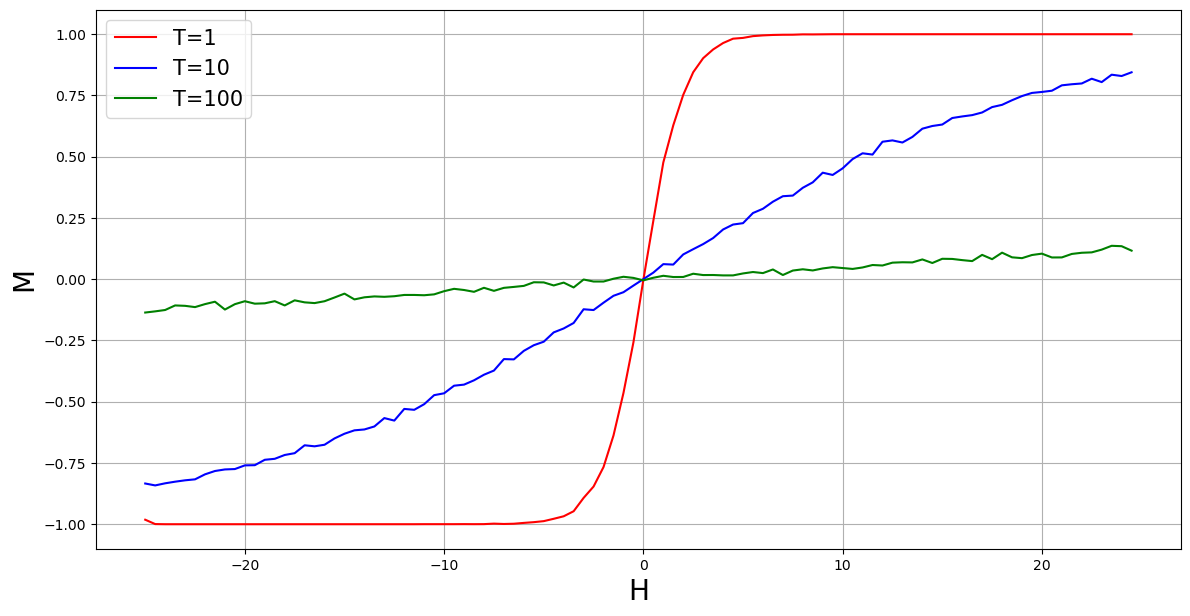

In [6]:
plt.plot(H,Iso1[6],label="T=1",color="red")
plt.plot(H,Iso2[6],label="T=10",color="blue")
plt.plot(H,Iso3[6],label="T=100",color="green")
plt.xlabel("H",fontsize=20)
plt.ylabel("M",fontsize=20)
plt.legend(fontsize=15,loc="best")
plt.grid()
plt.show()

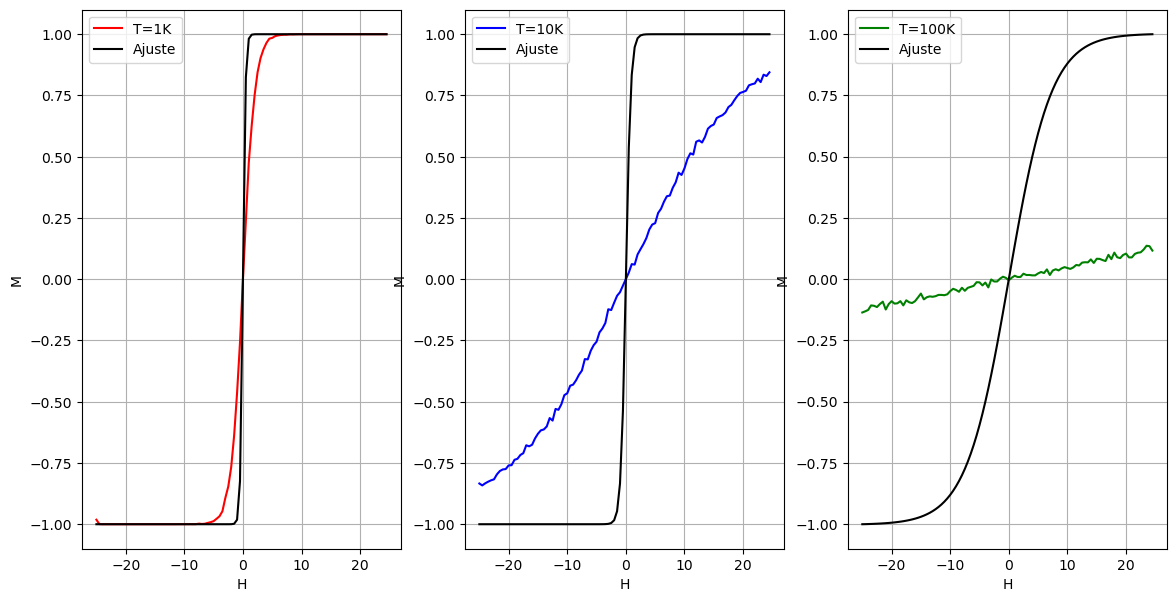

In [7]:
#Ajustemos las curvas de magnetización en función del campo magnético con una tangente hiperbólica
def f(x,param):
    return param[1]*np.tanh(param[0]*x)
param1=[1,1]
param2=[1,1]
param3=[1,1]
a1=Iso1[6]
a2=Iso2[6]
a3=Iso3[6]
def chi2_1(H,a1,param1):
    return np.sum((a1-f(H,param1))**2)
def chi2_2(H,a2,param2):
    return np.sum((a2-f(H,param2))**2)
def chi2_3(H,a3,param3):
    return np.sum((a3-f(H,param3))**2)
res1=minimize(chi2_1,H,args=(Iso1[6],param1),method="Powell")
res2=minimize(chi2_2,H,args=(Iso2[6],param2),method="Powell")
res3=minimize(chi2_3,H,args=(Iso3[6],param3),method="Powell")
y1=f(H,res1.x)
y2=f(H,res2.x)
y3=f(H,res3.x)
#Grafiquemos los ajustes con un subplot
plt.subplot(1,3,1)
plt.plot(H,Iso1[6],label="T=1K",color="red")
plt.plot(H,y1/max(y1),label="Ajuste",color="black")
plt.xlabel("H",fontsize=10)
plt.ylabel("M",fontsize=10)
plt.legend(fontsize=10,loc="best")
plt.grid()
plt.subplot(1,3,2)
plt.plot(H,Iso2[6],label="T=10K",color="blue")
plt.plot(H,y2/max(y2),label="Ajuste",color="black")
plt.xlabel("H",fontsize=10)
plt.ylabel("M",fontsize=10)
plt.legend(fontsize=10,loc="best")
plt.grid()
plt.subplot(1,3,3)
plt.plot(H,Iso3[6],label="T=100K",color="green")
plt.plot(H,y3/max(y3),label="Ajuste",color="black")
plt.xlabel("H",fontsize=10)
plt.ylabel("M",fontsize=10)
plt.legend(fontsize=10,loc="best")
plt.grid()
plt.show()

100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


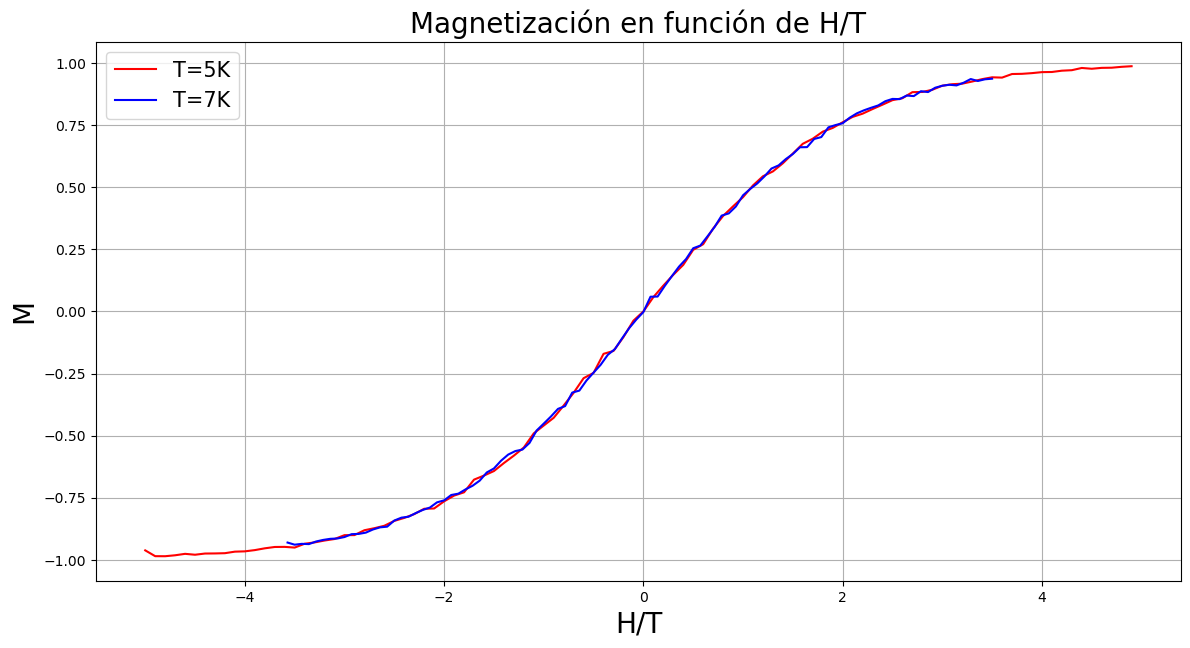

In [8]:
#Coprobemos la ley de estados correspondientes
#Para ello grafiquemos la magnetización en función del H/T
#Evaluemos la función para T=5K y T=7K
T4=5
T5=7    
Iso4=ising2D(L,T4,nsteps,J,H)
Iso5=ising2D(L,T5,nsteps,J,H)
plt.plot(H/T4,Iso4[6],label="T=5K",color="red")
plt.plot(H/T5,Iso5[6],label="T=7K",color="blue")
plt.title("Magnetización en función de H/T",fontsize=20)
plt.xlabel("H/T",fontsize=20)
plt.ylabel("M",fontsize=20)
plt.legend(fontsize=15,loc="best")
plt.grid()
plt.show()

100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


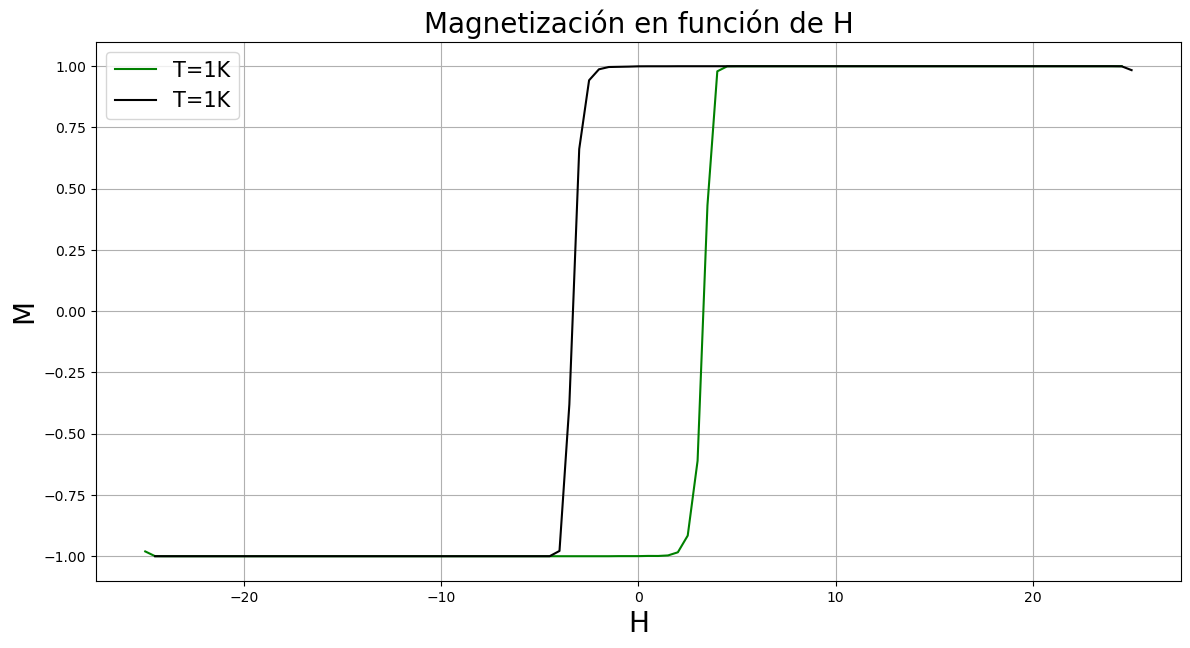

In [9]:
#Hagámos todo el análisis para el caso de J=1 y T=1 y ver si se presenta histeresis
h1=np.arange(-25,25,0.5) #campo magnetico
h2=np.arange(25,-25,-0.5) #campo magnetico para histeresis
J2=1
T6=1
Iso6=ising2D(L,T6,nsteps,J2,h1)
Iso7=ising2D(L,T6,nsteps,J2,h2)
plt.plot(h1,Iso6[6],label="T=1K",color="green")
plt.plot(h2,Iso7[6],label="T=1K",color="black")
plt.title("Magnetización en función de H",fontsize=20)
plt.xlabel("H",fontsize=20)
plt.ylabel("M",fontsize=20)
plt.legend(fontsize=15,loc="best")
plt.grid()
plt.show()

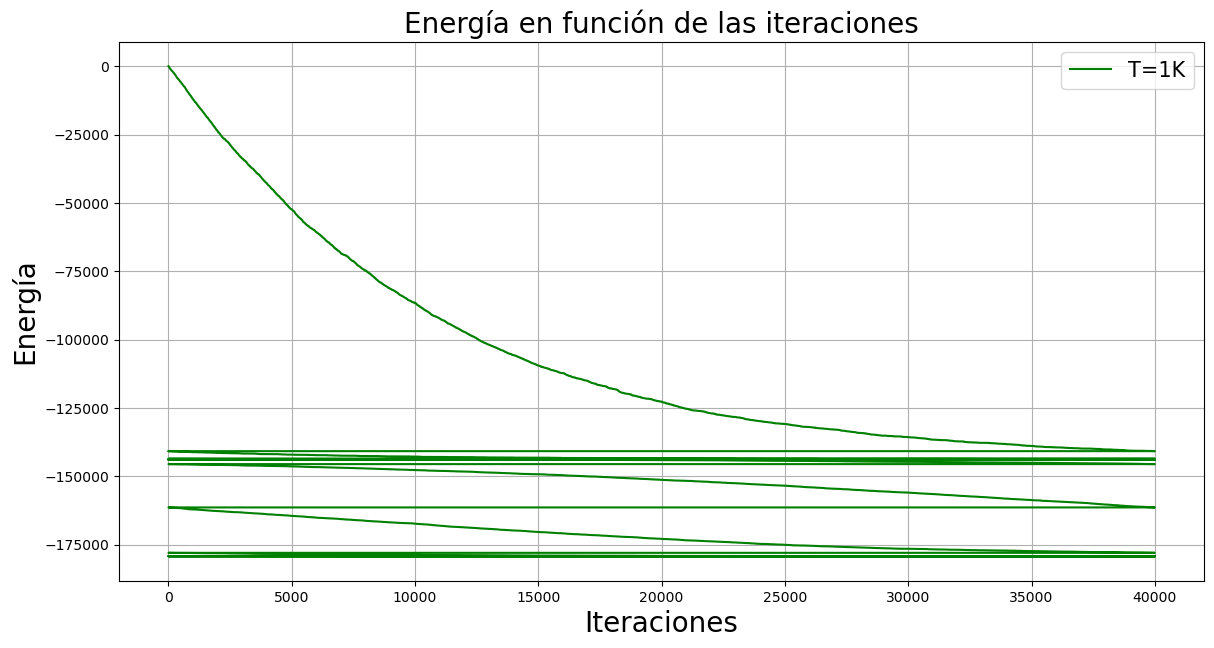

In [10]:
#Gráficamos la energía en función de las iteraciones
plt.plot(Iso6[8],Iso6[7],label="T=1K",color="green")
plt.title("Energía en función de las iteraciones",fontsize=20)
plt.xlabel("Iteraciones",fontsize=20)
plt.ylabel("Energía",fontsize=20)
plt.legend(fontsize=15,loc="best")
plt.grid()
plt.show()


In [11]:
#Por cuestiones de capacidad de mi maquina tuve que proponer un segundo código para las curvas dependientes de la temperatura





def initialstate(N):   
    ''' 
    Genera un estado aleatorio para una red de NxN
    '''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state



def mcmove(config, beta,N):
    '''
    Movimiento de Monte Carlo usando el algoritmo Metropolis
    '''
    
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config



def calcEnergy(config,N):
    '''
    Energía de una configuración dada
    '''
    energy = 0 
    
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/2.  # to compensate for over-counting



def calcMag(config):
    '''
    Magnetización de una configuración dada
    '''
    mag = np.sum(config)
    return mag

In [12]:




nt      = 32          # Número de puntos de temperatura
N       = 10          #  Lado de la red
eqSteps = 2**6        #  número de pasos de equilibrio
mcSteps = 2**10       #  número de pasos de Monte Carlo


T       = np.linspace(1.00, 4.00, nt); # Temperaturas
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt) # arrays para energía, magnetización, calor específico y susceptibilidad
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N)  # factores de normalización
# ciclo sobre las temperaturas



In [13]:
# ciclo sobre las temperaturas


for tt in range(nt):
    config = initialstate(N)         # generar una configuración aleatoria

    E1 = M1 = E2 = M2 = 0
    iT=1.0/T[tt]; iT2=iT*iT;
    
    for i in range(eqSteps):         # equilibra
        mcmove(config, iT,N)           # MOvis de Monte Carlo

    for i in range(mcSteps):
        mcmove(config, iT,N)           
        Ene = calcEnergy(config,N)     # calcula la energía
        Mag = calcMag(config)        # calcula la magnetización

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene


    # Guardar los valores de energía y magnetización
    E[tt] = n1*E1
    M[tt] = n1*M1
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT

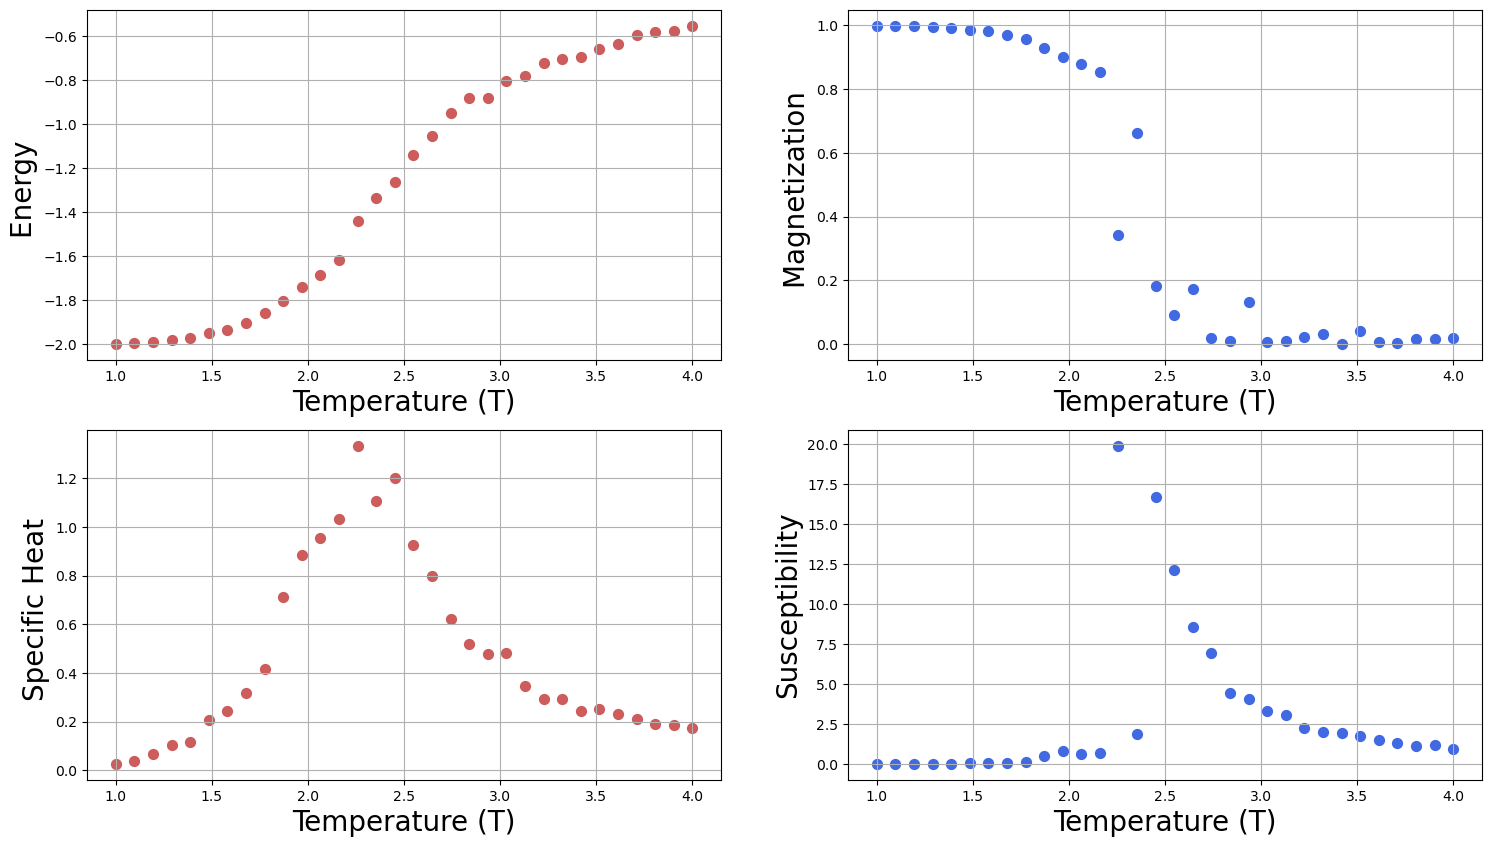

In [14]:
# Graficar las gráficas pedidas

f = plt.figure(figsize=(18, 10)); #  


sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');
plt.grid()


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M),s=50,marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');
plt.grid()


sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');  
plt.grid()


sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');
plt.grid()

/tmp/ipykernel_3498/919325271.py:2: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


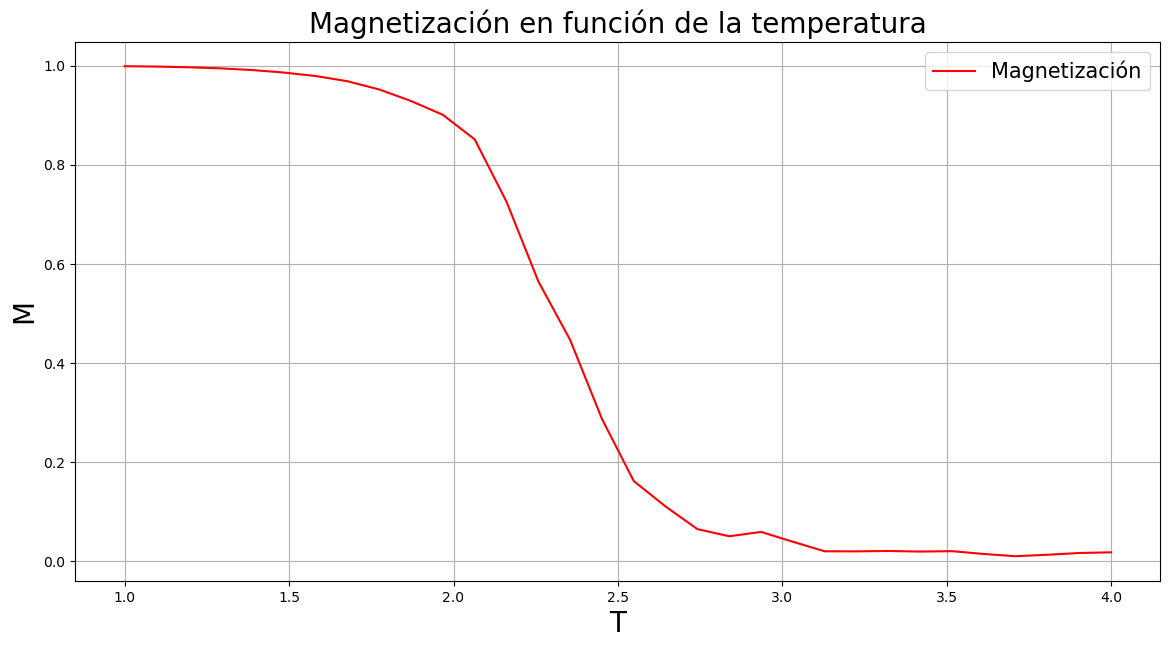

In [15]:
#Hagamos un ajuste de las graficas con gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d

#Graficamos la magnetización en función de la temperatura
plt.plot(T,gaussian_filter1d(abs(M),sigma=1),label="Magnetización",color="red")
plt.title("Magnetización en función de la temperatura",fontsize=20)
plt.xlabel("T",fontsize=20)
plt.ylabel("M",fontsize=20)
plt.legend(fontsize=15,loc="best")
plt.grid()
plt.show()


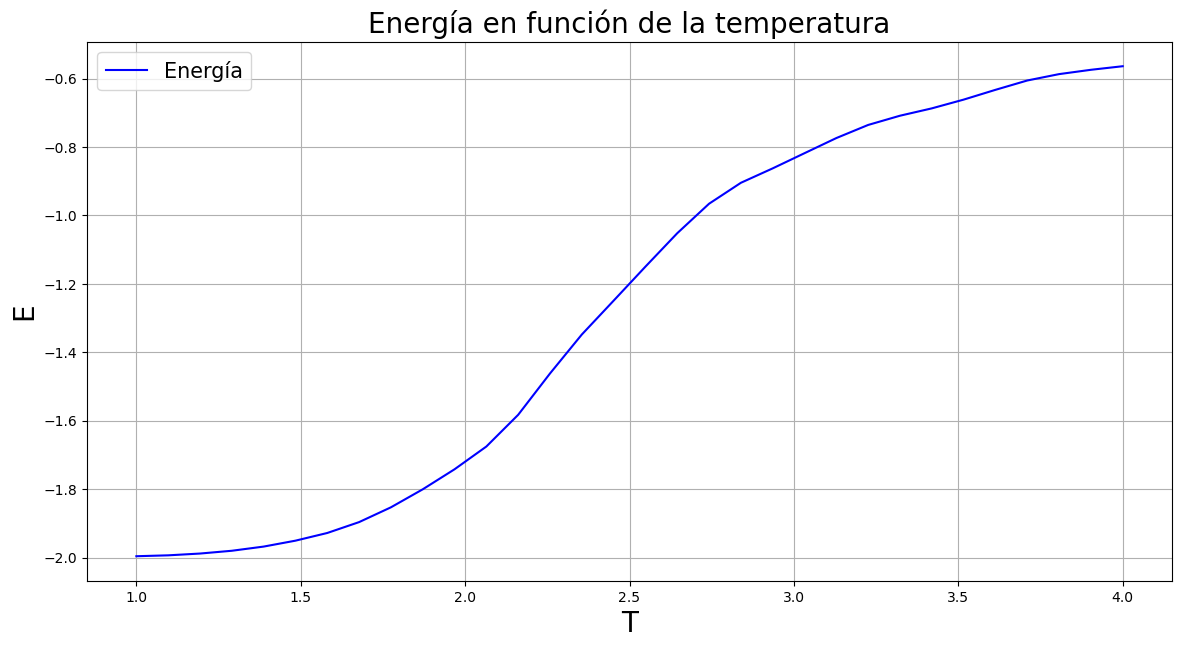

In [16]:
# Graficamos la energía en función de la temperatura
plt.plot(T,gaussian_filter1d(E,sigma=1),label="Energía",color="blue")
plt.title("Energía en función de la temperatura",fontsize=20)
plt.xlabel("T",fontsize=20)
plt.ylabel("E",fontsize=20)
plt.legend(fontsize=15,loc="best")
plt.grid()
plt.show()


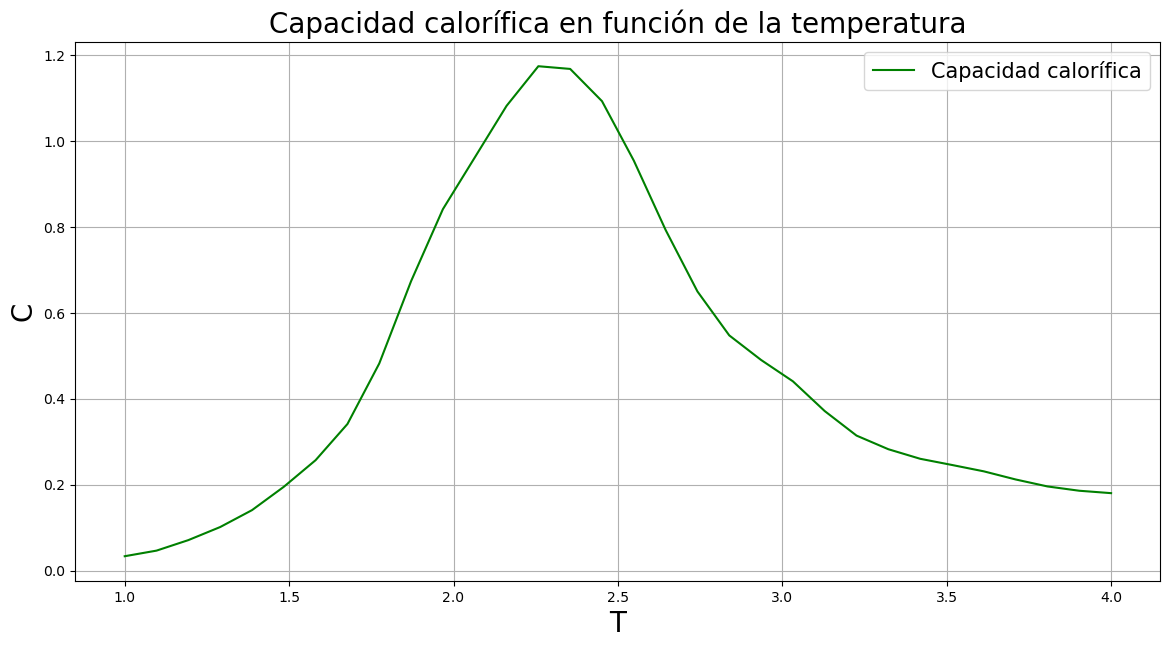

In [17]:
# Graficamos la capacidad calorífica en función de la temperatura
plt.plot(T,gaussian_filter1d(C,sigma=1),label="Capacidad calorífica",color="green")
plt.title("Capacidad calorífica en función de la temperatura",fontsize=20)
plt.xlabel("T",fontsize=20)
plt.ylabel("C",fontsize=20)
plt.legend(fontsize=15,loc="best")
plt.grid()
plt.show()


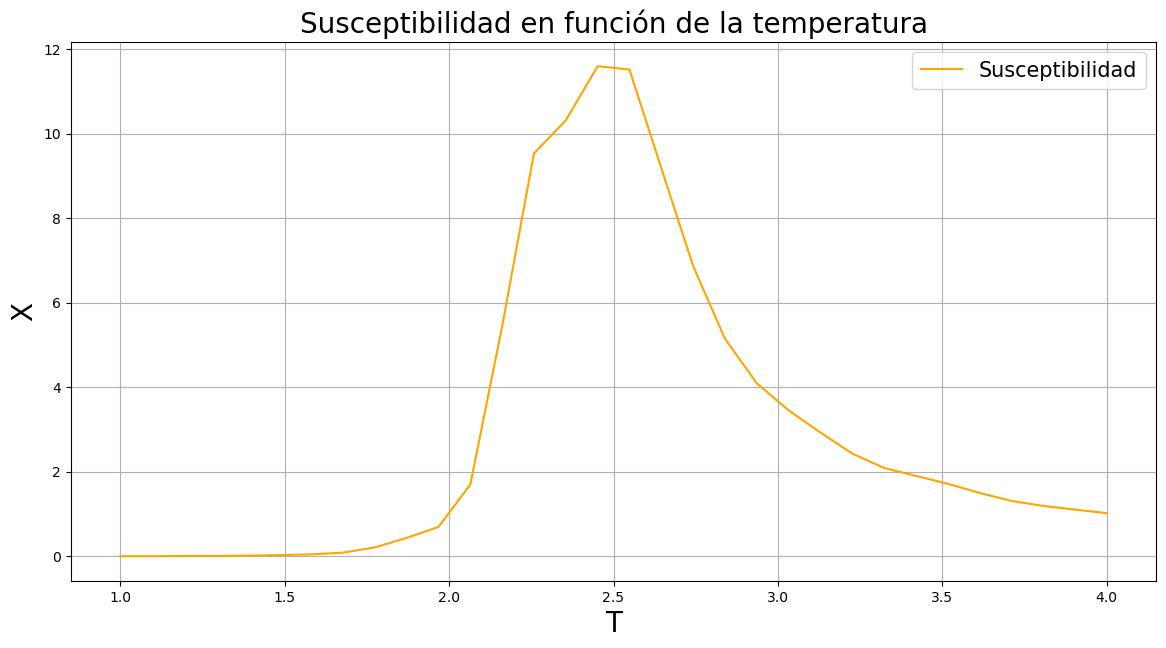

In [18]:
# Graficamos la susceptibilidad en función de la temperatura
plt.plot(T,gaussian_filter1d(X,sigma=1),label="Susceptibilidad",color="orange")
plt.title("Susceptibilidad en función de la temperatura",fontsize=20)
plt.xlabel("T",fontsize=20)
plt.ylabel("X",fontsize=20)
plt.legend(fontsize=15,loc="best")
plt.grid()
plt.show()
